# Богданов Александр Иванович, Б05-003

## Классификация даты документа

In [42]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import artm

In [2]:
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Обработка данных

Приведем данные к нужному формату.

In [3]:
data = pd.read_csv('drive/MyDrive/Data/lenta-ru-proccess.csv')
data = data[:60000]

In [4]:
filename_valid = 'drive/MyDrive/Data/texts_valid.vw.txt'
filename_train = 'drive/MyDrive/Data/texts_train.vw.txt'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()

            date = data.iloc[i]['date'].split('-')
            length = data.iloc[i]['len']
            month = date[1]
            year = date[2]

            tags = (str(data.iloc[i]['tags']).lower().strip()).split()

            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write(f"doc_{counter_valid} {' '.join(text)} |@len_class {length} |@tags_class {' '.join(tags)} |@month_class {month}\n")
                    counter_valid += 1
                    y_valid.append(year)
                else:
                    fout_train.write(f"doc_{counter_train} {' '.join(text)} |@len_class {length} |@tags_class {' '.join(tags)} |@month_class {month} |@year_class {year}\n")
                    counter_train += 1
                    y_train.append(year)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [6]:
with open('drive/MyDrive/Data/y_valid.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid))

with open('drive/MyDrive/Data/y_train.vw.txt', 'w') as f:
    f.write('\n'.join(y_train))

Создадим батчи

In [7]:
bv_train = artm.BatchVectorizer(data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000, target_folder='drive/MyDrive/Data/batches_train')
bv_valid = artm.BatchVectorizer(data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000, target_folder='drive/MyDrive/Data/batches_valid')

Создаем словарь

In [8]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='drive/MyDrive/Data/batches_train')

### Модель

In [9]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary, class_ids={'@default_class': 1.0}))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

  0%|          | 0/10 [00:00<?, ?it/s]

Посмотрим на перплексию

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


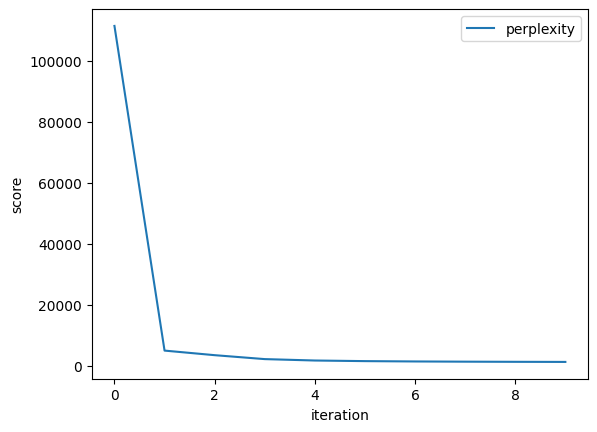

In [10]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

### Векторное представление

In [11]:
X_train = model.transform(bv_train)
X_train = X_train.T.to_numpy()
X_valid = model.transform(bv_valid)
X_valid = X_valid.T.to_numpy()

In [12]:
with open('drive/MyDrive/Data/y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')

with open('drive/MyDrive/Data/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Классификатор

В качасте классификатора будем использовать RandomForestClassifier

In [13]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

In [14]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.11      0.05      0.07        19
        2000       0.15      0.17      0.16        69
        2001       0.36      0.43      0.39        96
        2002       0.35      0.31      0.33       118

    accuracy                           0.30       302
   macro avg       0.25      0.24      0.24       302
weighted avg       0.30      0.30      0.29       302



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Классификатор достаточно плохо справляется с поставленной задачей

### Добавление модальности

Добавление тегов

In [16]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0,
                                                                    '@tags_class': 2.0})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
X_train = model.transform(bv_train)
X_train = X_train.T.to_numpy()
X_valid = model.transform(bv_valid)
X_valid = X_valid.T.to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.13      0.13      0.13        69
        2001       0.42      0.50      0.45        96
        2002       0.33      0.31      0.32       118

    accuracy                           0.31       302
   macro avg       0.22      0.24      0.23       302
weighted avg       0.29      0.31      0.30       302



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Стало только хуже

Добаление длины

In [20]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0,
                                                                    '@len_class': 2.0})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
X_train = model.transform(bv_train)
X_train = X_train.T.to_numpy()
X_valid = model.transform(bv_valid)
X_valid = X_valid.T.to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.13      0.13      0.13        69
        2001       0.36      0.45      0.40        96
        2002       0.39      0.35      0.37       118

    accuracy                           0.31       302
   macro avg       0.22      0.23      0.22       302
weighted avg       0.30      0.31      0.30       302



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Стало еще хуже

Добавление тегов и длины

In [25]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0,
                                                                    '@tags_class': 2.0,
                                                                    '@len_class': 2.0})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
X_train = model.transform(bv_train)
X_train = X_train.T.to_numpy()
X_valid = model.transform(bv_valid)
X_valid = X_valid.T.to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.10      0.10      0.10        69
        2001       0.37      0.45      0.40        96
        2002       0.25      0.23      0.24       118

    accuracy                           0.25       302
   macro avg       0.18      0.19      0.19       302
weighted avg       0.24      0.25      0.25       302



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Качество еще сильнее упало

### Добавление регуляризаторов

Воспользуемся регуляризаторами, у которых есть описание в документации: Smooth/Sparse Phi; Smooth/Sparse Theta

Рассмотрим Smooth/Sparse Phi: сглаживание и разреживание множеств.

In [30]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0,
                                                                    '@tags_class': 0.1,
                                                                    '@len_class': 0.1,
                                                                    '@month_class': 0.1})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
X_train = model.transform(bv_train)
X_train = X_train.T.to_numpy()
X_valid = model.transform(bv_valid)
X_valid = X_valid.T.to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.11      0.06      0.08        69
        2001       0.35      0.39      0.37        96
        2002       0.33      0.44      0.38       118

    accuracy                           0.31       302
   macro avg       0.20      0.22      0.20       302
weighted avg       0.26      0.31      0.28       302



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Стало чуть-чуть получше

Рассмотрим Smooth/Sparse Theta: сглаживание и разреживание матрицы.

In [35]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0,
                                                                    '@tags_class': 0.1,
                                                                    '@len_class': 0.1,
                                                                    '@month_class': 0.1})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

  0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
X_train = model.transform(bv_train)
X_train = X_train.T.to_numpy()
X_valid = model.transform(bv_valid)
X_valid = X_valid.T.to_numpy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       0.00      0.00      0.00        19
        2000       0.15      0.14      0.15        69
        2001       0.38      0.48      0.43        96
        2002       0.32      0.30      0.31       118

    accuracy                           0.30       302
   macro avg       0.21      0.23      0.22       302
weighted avg       0.28      0.30      0.29       302



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Результаты стали еще лучше

### Aнализ классификации модальности

In [45]:
model = artm.ARTM(num_topics=200, dictionary=dictionary, class_ids={'@default_class': 1.0,
                                                                    '@tags_class': 0.1,
                                                                    '@len_class': 0.1,
                                                                    '@month_class': 0.1,
                                                                    '@year_class': 3})
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))

model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
p_cd_test = model.transform(bv_valid, predict_class_id='@year_class').sort_index(ascending=True)

years = p_cd_test.index.values
y_pred = np.argmax(p_cd_test.to_numpy(), axis=0)

y_pred = [years[idx] for idx in y_pred]

In [47]:
print(classification_report(y_valid, y_pred, zero_division=1))

              precision    recall  f1-score   support

        1999       1.00      0.00      0.00        19
        2000       0.00      0.00      0.00        69
        2001       0.38      0.16      0.22        96
        2002       0.39      0.87      0.54       118

    accuracy                           0.39       302
   macro avg       0.44      0.26      0.19       302
weighted avg       0.34      0.39      0.28       302



Сильно улучшились метрики